In [1]:
pip install ../../

Defaulting to user installation because normal site-packages is not writeable
Processing /home/mehdi/code/Straph
  Preparing metadata (setup.py) ... done
  Created wheel for straph: filename=straph-0.3-py3-none-any.whl size=129891 sha256=6013b0d459e98f22693c1f979cf3548afdf74508c1b7dd9bc26d41d2ded03406
  Stored in directory: /tmp/pip-ephem-wheel-cache-yt1j5nye/wheels/37/09/70/7b86f721614374ec311fa16ed21dbb33c1959d2c6f80461dfd
Successfully built straph
  Attempting uninstall: straph
    Found existing installation: straph 0.3
    Uninstalling straph-0.3:
      Successfully uninstalled straph-0.3
Note: you may need to restart the kernel to use updated packages.


In [8]:
import straph as sg
import straph.betweenness as bt
import straph.betweenness.volumes as vol
import straph.paths.meta_walks as mw
import straph.betweenness.optimal_paths as opt
import operator
import math

In [3]:
def check_pre_cur_dij_bell(pre,pre2):
    for v in range(len(pre)):
        for t in pre[v].keys():
            if v > len(pre2) or t not in pre2[v].keys():
                print("problem", v,t, "not present in", pre2)
                return False
            if pre[v][t] != pre2[v][t]:
                print("problem", "v",v,"t",t,pre[v][t], pre2[v][t])
                return False
    return True
def check_pre_cur(pre,pre2,cur,cur2):
    return check_pre_cur_dij_bell(pre,pre2) and check_pre_cur_dij_bell(pre2,pre) and check_pre_cur_dij_bell(cur,cur2) and check_pre_cur_dij_bell(cur2,cur)

In [4]:
def all_check(S, events, events_reverse, neighbors, neighbors_inv, link_ind, b, fun, walk_type):
    for nod in S.nodes:
        pre, cur_best = bt.dijkstra_directed_dis_gen(S, nod, events, events_reverse, neighbors, neighbors_inv, link_ind, b, fun, walk_type)
        pre2, cur_best2 = bt.ford_bellman_directed_gen_dis(S, nod, events, events_reverse, neighbors, neighbors_inv, link_ind, b, fun, walk_type)
        pre3, cur_best3 = bt.bfs_directed_dis_gen(S, nod, events, events_reverse, neighbors, neighbors_inv, link_ind, b, fun, walk_type)
        if not check_pre_cur(pre,pre3, cur_best,cur_best3):
            return False,nod
    return True

In [5]:
N = 5
T = 7
n = 8
p = 0.15
def check(N,T,n,p):
    window = [1,T]
    for _ in range(N):
        #for c in [mw.Metawalk.co_sfp, mw.Metawalk.co_short]:
        for c in [opt.co_sh_im, opt.co_sfp_im]:
            for w in ["active", "passive"]:
                S = sg.erdos_renyi_discrete(window, n, p)
                events, events_reverse = bt.events_dic(S)
                link_ind = bt.link_index(S)
                neighbors, neighbors_inv = bt.neighbors_direct(S)
                b = operator.lt
                walk_type = "active"
                x = all_check(S, events, events_reverse, neighbors, neighbors_inv, link_ind, b, c, w)
                if not type(x) == bool:
                    nod = x[1]
                    print("nod", nod, "fun", c, "typewalk", w)
                    pre, cur_best = bt.dijkstra_directed_dis_gen(S, nod, events, events_reverse, neighbors, neighbors_inv, link_ind, b, c, w)
                    pre2, cur_best2 = bt.ford_bellman_directed_gen_dis(S, nod, events, events_reverse, neighbors, neighbors_inv, link_ind, b, c, w, com = 1)
                    pre3, cur_best3 = bt.bfs_directed_dis_gen(S, nod, events, events_reverse, neighbors, neighbors_inv, link_ind, b, c, w, com = 1)
                    
                    return S,nod,pre,pre3,cur_best,cur_best3
    return True
x = check(N,T,n,p)

In [10]:
import time
N = 40
T = 12
n = 20
p = 1/(n*T)
def check_time_synth(N,T,n,p, which=["dij", "bell", "bfs"]):
    tot = 0
    tot2 = 0
    tot3 = 0
    window = [1,T]
    for _ in range(N):
        for c in [opt.co_sfp_im]: #, mw.Metawalk.co_short
            for w in [ "passive"]: #"active",
                S = sg.erdos_renyi_discrete(window, n, p)
                print("nb edges", sum( len(S.link_presence[i])/2 for i in range(len(S.link_presence)) ), "nTlog(nT)", n*T*math.log(n*T))
                events, events_reverse = bt.events_dic(S)
#                 print(events)
                link_ind = bt.link_index(S)
                neighbors, neighbors_inv = bt.neighbors_direct(S)
                b = operator.lt
                for nod in S.nodes:
                    if "dij" in which:
                        st = time.time()
                        pre, cur_best = bt.dijkstra_directed_dis_gen(S, nod, events, events_reverse, neighbors, neighbors_inv, link_ind, b, c, w)
                        ed = time.time()
                        tot += (ed - st)
                    if "bell" in which:
                        st = time.time()
                        pre2, cur_best2 = bt.ford_bellman_directed_gen_dis(S, nod, events, events_reverse, neighbors, neighbors_inv, link_ind, b, c, w)
                        ed = time.time()
                        tot2 += (ed - st)
                    if "bfs" in which:
                        st = time.time()
                        pre3, cur_best3 = bt.bfs_directed_dis_gen(S, nod, events, events_reverse, neighbors, neighbors_inv, link_ind, b, c, w)
                        ed = time.time()
                        tot3 += (ed - st)
#     print("average dijkstra ", tot/(N*2*2), "average bellman ", tot2/(N*2*2))
#     print("gain", tot/tot2)
    return tot, tot2, tot3
                
# x = check_time_synth(N,T,n,p)

In [9]:
l = []
l2 = []
N = 200
gap = 50
for n in range(4,N+1,gap):
    print(n, " ", end = "")
    T = 1
    p = 1/(n*T)
    repet = 2
    l.append( (n,check_time_synth(repet,T,n,p)) )
    l2.append( (n, n/4 ))

4  54  104  154  

In [12]:
import math
l2 = []
for n in range(4,N+1,gap):
    l2.append( (n, n/math.log(n) ))

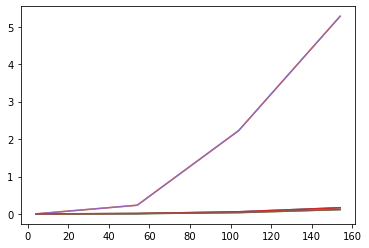

In [15]:
import matplotlib.pyplot as plt 
plt.plot(list(map(lambda x : x[0], l)), list(map(lambda x : x[1], l))
         ,list(map(lambda x : x[0], l)), list(map(lambda x : x[1], l))
        ) 
plt.show() 

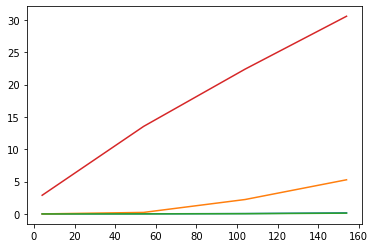

In [13]:
import matplotlib.pyplot as plt 
plt.plot(list(map(lambda x : x[0], l)), list(map(lambda x : x[1], l))
         ,list(map(lambda x : x[0], l2)), list(map(lambda x : x[1], l2))
        ) 
plt.show() 

In [20]:
#varies nodes
l = []
l2 = []
N = 204
gap = 80
which = ["dij", "bell","bfs"]
for n in range(4,N+1,gap):
    print(n, " ", end = "")
    T = 10
    p = 1/(10*n)
    repet = 1
    l.append( (n,check_time_synth(repet,T,n,p, which = which)) )

4  nb edges 4.0 nTlog(nT) 147.55517816455745
84  nb edges 89.0 nTlog(nT) 5656.057589143382
164  nb edges 172.0 nTlog(nT) 12140.02049414192


In [24]:
#varies times
l = []
l2 = []
N = 304
gap = 80
which = ["dij", "bell","bfs"]
for T in range(4,N+1,gap):
    n = int(math.sqrt(T))
    print("n,T",n,T, " ", end = "")
    p = 1/(10*n)
    repet = 1
    l.append( (n,check_time_synth(repet,T,n,p, which = which)) )

n,T 2 4  nb edges 1.0 nTlog(nT) 16.635532333438686
n,T 9 84  nb edges 68.0 nTlog(nT) 5010.799280391727
n,T 12 164  nb edges 174.0 nTlog(nT) 14926.833416740807
n,T 15 244  nb edges 352.0 nTlog(nT) 30031.099440607206


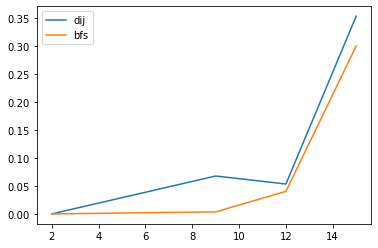

In [25]:
import matplotlib.pyplot as plt 
labels = which

for i in range(0,len(which),2):
# for i in range(len(labels)):
    plt.plot(list(map(lambda x : x[0], l)), list(map(lambda x : x[1][i], l)), label = labels[i] )
#          ,list(map(lambda x : x[0], l)), list(map(lambda x : x[1][1], l))
#          ,list(map(lambda x : x[0], l)), list(map(lambda x : x[1][2], l))
plt.legend()
plt.show() 